In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/Khóa luận tốt nghiệp/QA

/content/drive/.shortcut-targets-by-id/1T-TkLmhLIA8qodciANOIZEcC0W8CsU9V/Khóa luận tốt nghiệp/QA


In [4]:
!pip install genz-tokenize==1.2.7a2 -q 
!pip install vncorenlp -q 
!pip install tensorflow-addons -q

In [5]:
import tensorflow as tf
from genz_tokenize import Tokenize
import numpy as np
import pickle
import random
import math
from typing import Dict, List, Optional, Union, Tuple
from tqdm import tqdm
import tensorflow_addons as tfa
from vncorenlp import VnCoreNLP
from sklearn.model_selection import train_test_split

In [6]:
vncore_jar = '/content/drive/MyDrive/Khóa luận tốt nghiệp/Paragraph_Raking/Tensorflow/VnCoreNLP/VnCoreNLP-1.1.1.jar'
vncore = VnCoreNLP(vncore_jar)

In [7]:
with open('/content/drive/MyDrive/Khóa luận tốt nghiệp/QA/new_data.pkl', 'rb') as f:
    context, question, answer = pickle.load(f)

In [8]:
len(context)

21072

In [9]:
tokenize = Tokenize()

In [10]:
maxlen_c = 0
maxlen_q = 0
for i, j in zip(context, question):
    maxlen_c = max(maxlen_c, len(i.split()))
    maxlen_q = max(maxlen_q, len(j.split()))
maxlen_c, maxlen_q

(702, 87)

In [11]:
dem = 0
for i in context:
    if len(i.split())<800:
        dem+=1
dem, len(context)

(21072, 21072)

In [12]:
context = np.array(context)
question = np.array(question)
answer = np.array(answer)

order = [i for i in range(len(context))]
random.shuffle(order)

context = context[order]
question = question[order]
answer = answer[order]

In [13]:
y = []
for c, a in zip(context, answer):
    start = 0
    end = 0
    a = a.split()
    c = c.split()
    for i in range(0, len(c)-len(a)+1, 1):
        s = sum([c[i+j] == a[j] for j in range(len(a))])
        if s == len(a):
            start = i
            end = start+len(a)-1
            break
    y.append([start, end])
train_y = np.array(y)

In [14]:
context_val = context[:2000]
context_test = context[2000:3000]
context = context[3000:]

question_val = question[:2000]
question_test = question[2000:3000]
question = question[3000:]

y_val = y[:2000]
y_test = y[2000:3000]
y_train = y[3000:]

In [15]:
context.shape, question.shape, train_y.shape

((18072,), (18072,), (21072, 2))

In [16]:
label = ['ai', 'cai gi', 'con vat', 'nhu the nao', 'number', 'tai sao', 'thoi gian', 'time', 'thuc vat', 'yes no', 'location']
postag_label = ['B', 'Np', 'Nc', 'Nu', 'N', 'Ny', 'Ni', 'Nb', 'V', 'Vb', 'A', 'Ab', 'P', 'R', 'L', 'M', 'E', 'C', 'Cc', 'I', 'T', 'Y', 'Z', 'X', 'CH']


In [17]:
def int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def create_example(encode_input_ids, encode_attention_mask, postag, decode_input_ids, decode_attention_mask, y):
    feature = {
        "encode_input_ids": int64_feature(encode_input_ids),
        "encode_attention_mask": int64_feature(encode_attention_mask),
        'postag': int64_feature(postag),
        "decode_input_ids": int64_feature(decode_input_ids),
        "decode_attention_mask": int64_feature(decode_attention_mask),
        "y": int64_feature(y),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def getTypeOfWord(vncore, text):
    out = np.zeros(shape=(277, len(postag_label)), dtype = np.int64)
    pos = pos_tag(text, vncore)
    for i in range(len(pos)):
        if i == 277:
            print(pos)
        index_pos = postag_label.index(pos[i][1])
        out[i, index_pos] = 1
    return out.reshape(1, -1).tolist()[0]

def pos_tag(text, vncore):
    text = text.replace('_', ' ')
    tag = vncore.pos_tag(text)
    combine = []
    for i in tag:
        combine += i
    return combine

In [ ]:
with tf.io.TFRecordWriter("tfrecord_data/data_train.tfrecord") as tfrecord_writer:
    for e, v, y in tqdm(zip(question, context, y_train)):
        x = tokenize(e, max_len = 277, truncation = True, padding = True)
        encode_input_ids = x['input_ids']
        encode_attention_mask = x['attention_mask']
        postag = getTypeOfWord(vncore, e)
        x = tokenize(v, max_len = 800, truncation = True, padding = True)
        decode_input_ids = x['input_ids']
        decode_attention_mask = x['attention_mask']
        example = create_example(encode_input_ids, encode_attention_mask, postag, decode_input_ids, decode_attention_mask, y)
        tfrecord_writer.write(example.SerializeToString())

18072it [03:49, 78.60it/s]


In [ ]:
with tf.io.TFRecordWriter("tfrecord_data/data_val.tfrecord") as tfrecord_writer:
    for e, v, y in tqdm(zip(question_val, context_val, y_val)):
        x = tokenize(e, max_len = 277, truncation = True, padding = True)
        encode_input_ids = x['input_ids']
        encode_attention_mask = x['attention_mask']
        postag = getTypeOfWord(vncore, e)
        x = tokenize(v, max_len = 800, truncation = True, padding = True)
        decode_input_ids = x['input_ids']
        decode_attention_mask = x['attention_mask']
        example = create_example(encode_input_ids, encode_attention_mask, postag, decode_input_ids, decode_attention_mask, y)
        tfrecord_writer.write(example.SerializeToString())

2000it [00:22, 88.82it/s] 


In [ ]:
with tf.io.TFRecordWriter("tfrecord_data/data_test.tfrecord") as tfrecord_writer:
    for e, v, y in tqdm(zip(question_test, context_test, y_test)):
        x = tokenize(e, max_len = 277, truncation = True, padding = True)
        encode_input_ids = x['input_ids']
        encode_attention_mask = x['attention_mask']
        postag = getTypeOfWord(vncore, e)
        x = tokenize(v, max_len = 800, truncation = True, padding = True)
        decode_input_ids = x['input_ids']
        decode_attention_mask = x['attention_mask']
        example = create_example(encode_input_ids, encode_attention_mask, postag, decode_input_ids, decode_attention_mask, y)
        tfrecord_writer.write(example.SerializeToString())

1000it [00:11, 90.77it/s]


In [18]:
def parse_tfrecord_fn(example):
    feature = {
        "encode_input_ids": tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing = True),
        "encode_attention_mask": tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing = True),
        "postag": tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing = True),
        "decode_input_ids": tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing = True),
        "decode_attention_mask": tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing = True),
        "y": tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing = True),
    }
    example = tf.io.parse_single_example(example, feature)
    return example["encode_input_ids"], example["encode_attention_mask"], example["postag"], example["decode_input_ids"], example['decode_attention_mask'], example['y']



In [19]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 10
filenames = tf.io.gfile.glob('tfrecord_data/data_train.tfrecord')
ignore_order = tf.data.Options()
ignore_order.experimental_deterministic = False
dataset_train = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
dataset_train = dataset_train.with_options(ignore_order)
dataset_train = dataset_train.map(parse_tfrecord_fn, num_parallel_calls=AUTOTUNE)
dataset_train = dataset_train.cache()
dataset_train = dataset_train.shuffle(BATCH_SIZE * 10).batch(BATCH_SIZE)
dataset_train = dataset_train.prefetch(AUTOTUNE)

In [20]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 10
filenames = tf.io.gfile.glob('tfrecord_data/data_test.tfrecord')
ignore_order = tf.data.Options()
ignore_order.experimental_deterministic = False
dataset_test = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
dataset_test = dataset_test.with_options(ignore_order)
dataset_test = dataset_test.map(parse_tfrecord_fn, num_parallel_calls=AUTOTUNE)
dataset_test = dataset_test.cache()
dataset_test = dataset_test.shuffle(BATCH_SIZE * 10).batch(BATCH_SIZE)
dataset_test = dataset_test.prefetch(AUTOTUNE)

In [21]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 10
filenames = tf.io.gfile.glob('tfrecord_data/data_val.tfrecord')
ignore_order = tf.data.Options()
ignore_order.experimental_deterministic = False
dataset_val = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
dataset_val = dataset_val.with_options(ignore_order)
dataset_val = dataset_val.map(parse_tfrecord_fn, num_parallel_calls=AUTOTUNE)
dataset_val = dataset_val.cache()
dataset_val = dataset_val.shuffle(BATCH_SIZE * 10).batch(BATCH_SIZE)
dataset_val = dataset_val.prefetch(AUTOTUNE)

In [22]:
for x1, x2, x3, x4, x5, y in dataset_train:
    break
x1.shape, x3.shape, y.shape

(TensorShape([10, 277]), TensorShape([10, 6925]), TensorShape([10, 2]))

In [23]:
class Config:
    def __init__(
        self,
        input_vocab_size = 50265,
        target_vocab_size = 40000,
        max_position_embeddings=258,
        hidden_size = 256,
        initializer_range = 0.02,
        layer_norm_eps = 1e-6,
        hidden_dropout_prob = 0.1,
        attention_probs_dropout_prob = 0.1,
        num_attention_heads = 8,
        num_hidden_layers = 8,
        is_decoder = True,
        intermediate_size = 1024,
        type_vocab_size = 1
    ):
        self.input_vocab_size = input_vocab_size
        self.target_vocab_size = target_vocab_size
        self.max_position_embeddings = max_position_embeddings
        self.hidden_size = hidden_size
        self.initializer_range = initializer_range
        self.layer_norm_eps = layer_norm_eps
        self.hidden_dropout_prob = hidden_dropout_prob
        self.num_attention_heads = num_attention_heads
        self.num_hidden_layers = num_hidden_layers
        self.is_decoder = is_decoder
        self.intermediate_size = intermediate_size
        self.attention_probs_dropout_prob = attention_probs_dropout_prob
        self.type_vocab_size = type_vocab_size
        

In [24]:
class TFRobertaEmbeddings(tf.keras.layers.Layer):
    """
    Same as BertEmbeddings with a tiny tweak for positional embeddings indexing.
    """

    def __init__(self, config, vocab_size, **kwargs):
        super().__init__(**kwargs)

        self.padding_idx = 0
        self.vocab_size = vocab_size
        self.type_vocab_size = config.type_vocab_size
        self.hidden_size = config.hidden_size
        self.max_position_embeddings = config.max_position_embeddings
        self.initializer_range = config.initializer_range
        self.LayerNorm = tf.keras.layers.LayerNormalization(epsilon=config.layer_norm_eps, name="LayerNorm")
        self.dropout = tf.keras.layers.Dropout(rate=config.hidden_dropout_prob)

    def build(self, input_shape: tf.TensorShape):
        with tf.name_scope("word_embeddings"):
            self.weight = self.add_weight(
                name="weight",
                shape=[self.vocab_size, self.hidden_size],
                initializer=get_initializer(self.initializer_range),
            )

        with tf.name_scope("token_type_embeddings"):
            self.token_type_embeddings = self.add_weight(
                name="embeddings",
                shape=[self.type_vocab_size, self.hidden_size],
                initializer=get_initializer(self.initializer_range),
            )

        with tf.name_scope("position_embeddings"):
            self.position_embeddings = self.add_weight(
                name="embeddings",
                shape=[self.max_position_embeddings, self.hidden_size],
                initializer=get_initializer(self.initializer_range),
            )

        super().build(input_shape)

    def create_position_ids_from_input_ids(self, input_ids, past_key_values_length=0):
        mask = tf.cast(tf.math.not_equal(input_ids, self.padding_idx), dtype=input_ids.dtype)
        incremental_indices = (tf.math.cumsum(mask, axis=1) + past_key_values_length) * mask

        return incremental_indices + self.padding_idx

    def call(
        self,
        input_ids=None,
        position_ids=None,
        token_type_ids=None,
        inputs_embeds=None,
        past_key_values_length=0,
        training=False,
    ):
        """
        Applies embedding based on inputs tensor.
        Returns:
            final_embeddings (`tf.Tensor`): output embedding tensor.
        """
        assert not (input_ids is None and inputs_embeds is None)

        if input_ids is not None:
            inputs_embeds = tf.gather(params=self.weight, indices=input_ids)

        input_shape = shape_list(inputs_embeds)[:-1]

        if token_type_ids is None:
            token_type_ids = tf.fill(dims=input_shape, value=0)

        if position_ids is None:
            if input_ids is not None:
                # Create the position ids from the input token ids. Any padded tokens remain padded.
                position_ids = self.create_position_ids_from_input_ids(
                    input_ids=input_ids, past_key_values_length=past_key_values_length
                )
            else:
                position_ids = tf.expand_dims(
                    tf.range(start=self.padding_idx + 1, limit=input_shape[-1] + self.padding_idx + 1), axis=0
                )

        position_embeds = tf.gather(params=self.position_embeddings, indices=position_ids)
        token_type_embeds = tf.gather(params=self.token_type_embeddings, indices=token_type_ids)
        final_embeddings = inputs_embeds + position_embeds + token_type_embeds
        final_embeddings = self.LayerNorm(inputs=final_embeddings)
        final_embeddings = self.dropout(inputs=final_embeddings, training=training)

        return final_embeddings

In [25]:
def get_initializer(initializer_range: float = 0.02) -> tf.initializers.TruncatedNormal:
    return tf.keras.initializers.TruncatedNormal(stddev=initializer_range)

In [26]:
def shape_list(tensor: Union[tf.Tensor, np.ndarray]) -> List[int]:
    if isinstance(tensor, np.ndarray):
        return list(tensor.shape)

    dynamic = tf.shape(tensor)

    if tensor.shape == tf.TensorShape(None):
        return dynamic

    static = tensor.shape.as_list()

    return [dynamic[i] if s is None else s for i, s in enumerate(static)]

In [27]:
class TFRobertaSelfAttention(tf.keras.layers.Layer):
    def __init__(self, config, **kwargs):
        super().__init__(**kwargs)

        if config.hidden_size % config.num_attention_heads != 0:
            raise ValueError(
                f"The hidden size ({config.hidden_size}) is not a multiple of the number "
                f"of attention heads ({config.num_attention_heads})"
            )

        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        self.sqrt_att_head_size = math.sqrt(self.attention_head_size)

        self.query = tf.keras.layers.Dense(
            units=self.all_head_size, kernel_initializer=get_initializer(config.initializer_range), name="query"
        )
        self.key = tf.keras.layers.Dense(
            units=self.all_head_size, kernel_initializer=get_initializer(config.initializer_range), name="key"
        )
        self.value = tf.keras.layers.Dense(
            units=self.all_head_size, kernel_initializer=get_initializer(config.initializer_range), name="value"
        )
        self.dropout = tf.keras.layers.Dropout(rate=config.attention_probs_dropout_prob)

        self.is_decoder = config.is_decoder

    def transpose_for_scores(self, tensor: tf.Tensor, batch_size: int) -> tf.Tensor:
        # Reshape from [batch_size, seq_length, all_head_size] to [batch_size, seq_length, num_attention_heads, attention_head_size]
        tensor = tf.reshape(tensor=tensor, shape=(batch_size, -1, self.num_attention_heads, self.attention_head_size))

        # Transpose the tensor from [batch_size, seq_length, num_attention_heads, attention_head_size] to [batch_size, num_attention_heads, seq_length, attention_head_size]
        return tf.transpose(tensor, perm=[0, 2, 1, 3])

    def call(
        self,
        hidden_states: tf.Tensor,
        attention_mask: tf.Tensor,
        head_mask: tf.Tensor,
        encoder_hidden_states: tf.Tensor,
        encoder_attention_mask: tf.Tensor,
        past_key_value: Tuple[tf.Tensor],
        output_attentions: bool,
        training: bool = False,
    ) -> Tuple[tf.Tensor]:
        batch_size = shape_list(hidden_states)[0]
        mixed_query_layer = self.query(inputs=hidden_states)

        # If this is instantiated as a cross-attention module, the keys
        # and values come from an encoder; the attention mask needs to be
        # such that the encoder's padding tokens are not attended to.
        is_cross_attention = encoder_hidden_states is not None

        if is_cross_attention and past_key_value is not None:
            # reuse k,v, cross_attentions
            key_layer = past_key_value[0]
            value_layer = past_key_value[1]
            attention_mask = encoder_attention_mask
        elif is_cross_attention:
            key_layer = self.transpose_for_scores(self.key(inputs=encoder_hidden_states), batch_size)
            value_layer = self.transpose_for_scores(self.value(inputs=encoder_hidden_states), batch_size)
            attention_mask = encoder_attention_mask
        elif past_key_value is not None:
            key_layer = self.transpose_for_scores(self.key(inputs=hidden_states), batch_size)
            value_layer = self.transpose_for_scores(self.value(inputs=hidden_states), batch_size)
            key_layer = tf.concat([past_key_value[0], key_layer], axis=2)
            value_layer = tf.concat([past_key_value[1], value_layer], axis=2)
        else:
            key_layer = self.transpose_for_scores(self.key(inputs=hidden_states), batch_size)
            value_layer = self.transpose_for_scores(self.value(inputs=hidden_states), batch_size)

        query_layer = self.transpose_for_scores(mixed_query_layer, batch_size)

        if self.is_decoder:
            past_key_value = (key_layer, value_layer)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        # (batch size, num_heads, seq_len_q, seq_len_k)
        attention_scores = tf.matmul(query_layer, key_layer, transpose_b=True)
        dk = tf.cast(self.sqrt_att_head_size, dtype=attention_scores.dtype)
        attention_scores = tf.divide(attention_scores, dk)

        if attention_mask is not None:
            # Apply the attention mask is (precomputed for all layers in TFRobertaModel call() function)
            attention_scores = tf.add(attention_scores, attention_mask)

        # Normalize the attention scores to probabilities.
        attention_probs = tf.nn.softmax(logits=attention_scores, axis=-1)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(inputs=attention_probs, training=training)

        # Mask heads if we want to
        if head_mask is not None:
            attention_probs = tf.multiply(attention_probs, head_mask)

        attention_output = tf.matmul(attention_probs, value_layer)
        attention_output = tf.transpose(attention_output, perm=[0, 2, 1, 3])

        # (batch_size, seq_len_q, all_head_size)
        attention_output = tf.reshape(tensor=attention_output, shape=(batch_size, -1, self.all_head_size))
        outputs = (attention_output, attention_probs) if output_attentions else (attention_output,)

        if self.is_decoder:
            outputs = outputs + (past_key_value,)
        return outputs # tuple

In [28]:
class TFRobertaSelfOutput(tf.keras.layers.Layer):
    def __init__(self, config, **kwargs):
        super().__init__(**kwargs)

        self.dense = tf.keras.layers.Dense(
            units=config.hidden_size, kernel_initializer=get_initializer(config.initializer_range), name="dense"
        )
        self.LayerNorm = tf.keras.layers.LayerNormalization(epsilon=config.layer_norm_eps, name="LayerNorm")
        self.dropout = tf.keras.layers.Dropout(rate=config.hidden_dropout_prob)

    def call(self, hidden_states: tf.Tensor, input_tensor: tf.Tensor, training: bool = False) -> tf.Tensor:
        hidden_states = self.dense(inputs=hidden_states)
        hidden_states = self.dropout(inputs=hidden_states, training=training)
        hidden_states = self.LayerNorm(inputs=hidden_states + input_tensor)

        return hidden_states

In [29]:
class TFRobertaAttention(tf.keras.layers.Layer):
    def __init__(self, config, **kwargs):
        super().__init__(**kwargs)

        self.self_attention = TFRobertaSelfAttention(config, name="self")
        self.dense_output = TFRobertaSelfOutput(config, name="output")

    def call(
        self,
        input_tensor: tf.Tensor,
        attention_mask: tf.Tensor,
        head_mask: tf.Tensor,
        encoder_hidden_states: tf.Tensor,
        encoder_attention_mask: tf.Tensor,
        past_key_value: Tuple[tf.Tensor],
        output_attentions: bool,
        training: bool = False,
    ) -> Tuple[tf.Tensor]:
        self_outputs = self.self_attention(
            hidden_states=input_tensor,
            attention_mask=attention_mask,
            head_mask=head_mask,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_attention_mask,
            past_key_value=past_key_value,
            output_attentions=output_attentions,
            training=training,
        )
        attention_output = self.dense_output(
            hidden_states=self_outputs[0], input_tensor=input_tensor, training=training
        )
        # add attentions (possibly with past_key_value) if we output them
        outputs = (attention_output,) + self_outputs[1:]

        return outputs

In [30]:
class TFRobertaIntermediate(tf.keras.layers.Layer):
    def __init__(self, config, **kwargs):
        super().__init__(**kwargs)

        self.dense = tf.keras.layers.Dense(
            units=config.intermediate_size, kernel_initializer=get_initializer(config.initializer_range), name="dense"
        )
        self.intermediate_act_fn = tf.nn.gelu

    def call(self, hidden_states: tf.Tensor) -> tf.Tensor:
        hidden_states = self.dense(inputs=hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)

        return hidden_states


In [31]:
class TFRobertaOutput(tf.keras.layers.Layer):
    def __init__(self, config, **kwargs):
        super().__init__(**kwargs)

        self.dense = tf.keras.layers.Dense(
            units=config.hidden_size, kernel_initializer=get_initializer(config.initializer_range), name="dense"
        )
        self.LayerNorm = tf.keras.layers.LayerNormalization(epsilon=config.layer_norm_eps, name="LayerNorm")
        self.dropout = tf.keras.layers.Dropout(rate=config.hidden_dropout_prob)

    def call(self, hidden_states: tf.Tensor, input_tensor: tf.Tensor, training: bool = False) -> tf.Tensor:
        hidden_states = self.dense(inputs=hidden_states)
        hidden_states = self.dropout(inputs=hidden_states, training=training)
        hidden_states = self.LayerNorm(inputs=hidden_states + input_tensor)

        return hidden_states

In [32]:
class TFRobertaEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, config, **kwargs):
        super().__init__(**kwargs)

        self.attention = TFRobertaAttention(config, name="attention")
        self.intermediate = TFRobertaIntermediate(config, name="intermediate")
        self.bert_output = TFRobertaOutput(config, name="output")

    def call(
        self,
        hidden_states: tf.Tensor,
        attention_mask: tf.Tensor,
        head_mask: tf.Tensor,
        past_key_value: Optional[Tuple[tf.Tensor]],
        output_attentions: bool,
        training: bool = False,
    ) -> Tuple[tf.Tensor]:
        # decoder uni-directional self-attention cached key/values tuple is at positions 1,2
        self_attn_past_key_value = past_key_value[:2] if past_key_value is not None else None
        self_attention_outputs = self.attention(
            input_tensor=hidden_states,
            attention_mask=attention_mask,
            head_mask=head_mask,
            encoder_hidden_states=None,
            encoder_attention_mask=None,
            past_key_value=self_attn_past_key_value,
            output_attentions=output_attentions,
            training=training,
        )
        attention_output = self_attention_outputs[0]

        outputs = self_attention_outputs[1:]  # add self attentions if we output attention weights

        intermediate_output = self.intermediate(hidden_states=attention_output)
        layer_output = self.bert_output(
            hidden_states=intermediate_output, input_tensor=attention_output, training=training
        )
        outputs = (layer_output,) + outputs  # add attentions if we output them
        return outputs

In [33]:
class TFRobertaEncoder(tf.keras.layers.Layer):
    def __init__(self, config, **kwargs):
        super().__init__(**kwargs)
        self.config = config
        self.layer = [TFRobertaEncoderLayer(config, name=f"layer_._{i}") for i in range(config.num_hidden_layers)]
        
    def call(
        self,
        hidden_states: tf.Tensor,
        attention_mask: tf.Tensor,
        head_mask: tf.Tensor,
        past_key_values: Optional[Tuple[Tuple[tf.Tensor]]],
        training: bool = False,
    ) -> tf.Tensor:
        attention_mask_shape = shape_list(attention_mask)
        extended_attention_mask = tf.reshape(
                attention_mask, (attention_mask_shape[0], 1, 1, attention_mask_shape[1])
        )
        extended_attention_mask = tf.cast(extended_attention_mask, dtype=hidden_states.dtype)
        one_cst = tf.constant(1.0, dtype=hidden_states.dtype)
        ten_thousand_cst = tf.constant(-10000.0, dtype=hidden_states.dtype)
        extended_attention_mask = tf.multiply(tf.subtract(one_cst, extended_attention_mask), ten_thousand_cst)

        for i, layer_module in enumerate(self.layer):

            past_key_value = past_key_values[i] if past_key_values is not None else None

            layer_outputs = layer_module(
                hidden_states=hidden_states,
                attention_mask=extended_attention_mask,
                head_mask=head_mask[i],
                past_key_value=past_key_value,
                output_attentions=True,
                training=training,
            )
            hidden_states = layer_outputs[0]

        return hidden_states

In [34]:
class TFRobertaDecoderLayer(tf.keras.layers.Layer):
    def __init__(self, config, **kwargs):
        super().__init__(**kwargs)

        self.attention = TFRobertaAttention(config, name="attention")

        self.crossattention = TFRobertaAttention(config, name="crossattention")
        self.intermediate = TFRobertaIntermediate(config, name="intermediate")
        self.bert_output = TFRobertaOutput(config, name="output")

    def call(
        self,
        hidden_states: tf.Tensor,
        attention_mask: tf.Tensor,
        head_mask: tf.Tensor,
        encoder_hidden_states: Optional[tf.Tensor],
        encoder_attention_mask: Optional[tf.Tensor],
        past_key_value: Optional[Tuple[tf.Tensor]],
        output_attentions: bool,
        training: bool = False,
    ) -> tf.Tensor:
        # decoder uni-directional self-attention cached key/values tuple is at positions 1,2
        self_attn_past_key_value = past_key_value[:2] if past_key_value is not None else None
        
        self_attention_outputs = self.attention(
            input_tensor=hidden_states,
            attention_mask=attention_mask,
            head_mask=head_mask,
            encoder_hidden_states=None,
            encoder_attention_mask=None,
            past_key_value=self_attn_past_key_value,
            output_attentions=output_attentions,
            training=training,
        )
        attention_output = self_attention_outputs[0]

        # if decoder, the last output is tuple of self-attn cache
        outputs = self_attention_outputs[1:-1]
        present_key_value = self_attention_outputs[-1]

        cross_attn_present_key_value = None
        # cross_attn cached key/values tuple is at positions 3,4 of past_key_value tuple
        cross_attn_past_key_value = past_key_value[-2:] if past_key_value is not None else None
        cross_attention_outputs = self.crossattention(
            input_tensor=attention_output,
            attention_mask=attention_mask,
            head_mask=head_mask,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_attention_mask,
            past_key_value=cross_attn_past_key_value,
            output_attentions=output_attentions,
            training=training,
        )
        attention_output = cross_attention_outputs[0]
        outputs = outputs + cross_attention_outputs[1:-1]  # add cross attentions if we output attention weights

        # add cross-attn cache to positions 3,4 of present_key_value tuple
        cross_attn_present_key_value = cross_attention_outputs[-1]
        present_key_value = present_key_value + cross_attn_present_key_value

        intermediate_output = self.intermediate(hidden_states=attention_output)
        layer_output = self.bert_output(
            hidden_states=intermediate_output, input_tensor=attention_output, training=training
        )
        outputs = (layer_output,) + outputs  # add attentions if we output them

        # if decoder, return the attn key/values as the last output
        outputs = outputs + (present_key_value,)
        return outputs

In [35]:
class TFRobertaDecoder(tf.keras.layers.Layer):
    def __init__(self, config, **kwargs):
        super().__init__(**kwargs)
        self.config = config
        self.layer = [TFRobertaDecoderLayer(config, name=f"layer_._{i}") for i in range(config.num_hidden_layers)]

    def call(
        self,
        hidden_states: tf.Tensor,
        attention_mask: tf.Tensor,
        head_mask: tf.Tensor,
        encoder_hidden_states: Optional[tf.Tensor],
        encoder_attention_mask: Optional[tf.Tensor],
        past_key_values: Optional[Tuple[Tuple[tf.Tensor]]],
        training: bool = False,
    ) -> tf.Tensor:
        attention_mask_shape = shape_list(attention_mask)
        input_shape = shape_list(hidden_states)
        batch_size, seq_length, _ = input_shape
        mask_seq_length = seq_length
        seq_ids = tf.range(mask_seq_length)

        causal_mask = tf.less_equal(
                tf.tile(seq_ids[None, None, :], (batch_size, mask_seq_length, 1)),
                seq_ids[None, :, None],
        )

        causal_mask = tf.cast(causal_mask, dtype=attention_mask.dtype)
        extended_attention_mask = causal_mask * attention_mask[:, None, :]
        attention_mask_shape = shape_list(extended_attention_mask)
        extended_attention_mask = tf.reshape(
            extended_attention_mask, (attention_mask_shape[0], 1, attention_mask_shape[1], attention_mask_shape[2])
        )

        extended_attention_mask = tf.cast(extended_attention_mask, dtype=hidden_states.dtype)
        one_cst = tf.constant(1.0, dtype=hidden_states.dtype)
        ten_thousand_cst = tf.constant(-10000.0, dtype=hidden_states.dtype)
        extended_attention_mask = tf.multiply(tf.subtract(one_cst, extended_attention_mask), ten_thousand_cst)

        encoder_attention_mask = tf.cast(encoder_attention_mask, dtype=extended_attention_mask.dtype)
        encoder_extended_attention_mask = encoder_attention_mask[:, None, None, :]
        
        encoder_extended_attention_mask = (1.0 - encoder_extended_attention_mask) * -10000.0
        
        for i, layer_module in enumerate(self.layer):

            past_key_value = past_key_values[i] if past_key_values is not None else None

            layer_outputs = layer_module(
                hidden_states=hidden_states,
                attention_mask=extended_attention_mask,
                head_mask=head_mask[i],
                encoder_hidden_states=encoder_hidden_states,
                encoder_attention_mask=encoder_extended_attention_mask,
                past_key_value=past_key_value,
                output_attentions=True,
                training=training,
            )
            hidden_states = layer_outputs[0]
        return hidden_states

In [36]:

class Embedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, dim, max_position_embeddings,  **kwargs):
        super().__init__(**kwargs)
        self.vocab_size = vocab_size
        self.dim = dim
        self.max_position_embeddings = max_position_embeddings
        self.LayerNorm = tf.keras.layers.LayerNormalization(epsilon=1e-12, name="LayerNorm")
        self.dropout = tf.keras.layers.Dropout(rate=0.1)

    def build(self, input_shape: tf.TensorShape):
        with tf.name_scope("word_embeddings"):
            self.weight = self.add_weight(
                name="weight",
                shape=[self.vocab_size, self.dim],
            )

        with tf.name_scope("position_embeddings"):
            self.position_embeddings = self.add_weight(
                name="embeddings",
                shape=[self.max_position_embeddings, self.dim],
            )
        super().build(input_shape)

    def call(self, input_ids=None):
        inputs_embeds = tf.gather(params=self.weight, indices=input_ids)
        input_shape = tf.shape(input_ids)
        position_ids = tf.expand_dims(tf.range(start=0, limit=input_shape[-1]), axis=0)
        position_embeds = tf.gather(params=self.position_embeddings, indices=position_ids)
        final_embeddings = inputs_embeds + position_embeds
        final_embeddings = self.LayerNorm(inputs=final_embeddings)
        final_embeddings = self.dropout(inputs=final_embeddings)
        return final_embeddings

class FeedFoward(tf.keras.layers.Layer):
    def __init__(self, d_model, num_class):
        super(FeedFoward, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(d_model)
        self.dropout = tf.keras.layers.Dropout(0.2)
        self.out = tf.keras.layers.Dense(num_class, activation = 'softmax')
    
    def call(self, inputs):
        inputs = self.flatten(inputs)
        x = self.fc1(inputs)
        x = self.dropout(x)
        return self.out(x)
class ClassifyModel(tf.keras.Model):
    def __init__(self, vocab_size,max_position_embeddings, d_model, num_heads, num_class):
        super(ClassifyModel, self).__init__()
        self.embedding = Embedding(vocab_size, d_model, max_position_embeddings)
        self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads, d_model, dropout = 0.1)
        self.fc = tf.keras.layers.Dense(1)
        self.fw = FeedFoward(d_model, num_class)
    def call(self, inputs):
        x = self.embedding(inputs)
        mask = self.mask(inputs)
        out_mha = self.mha(x, x, x)
        x = self.fc(self.layernorm(x+out_mha))
        return self.fw(x)

    def mask(self, inputs):
        masks = tf.logical_not(tf.math.equal(inputs, 0))
        masks = tf.cast(masks, dtype = tf.float32)
        return masks[:, tf.newaxis, tf.newaxis, :]

model_cls = ClassifyModel(tokenize.vocab_size(), 1000, 256, 3, len(label))

def fullConnected(d_model):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(d_model*2, activation='gelu'))
    model.add(tf.keras.layers.Dense(d_model, activation = 'sigmoid'))
    return model

class QuestionAnalys(tf.keras.Model):
    def __init__(self, d_model, maxlen, model_cls, num_heads):
        super(QuestionAnalys, self).__init__()
        self.model_cls = model_cls
        self.model_cls.trainable = False

        self.mha1 = tf.keras.layers.MultiHeadAttention(num_heads, d_model)
        self.mha2 = tf.keras.layers.MultiHeadAttention(num_heads, d_model)

        self.layerNorm1 = tf.keras.layers.LayerNormalization()
        self.layerNorm2 = tf.keras.layers.LayerNormalization()

        self.fc1 = fullConnected(d_model)
        self.fc2 = fullConnected(d_model)
        self.fc3 = fullConnected(d_model)

        self.fc_postag = tf.keras.layers.Dense(d_model)
        self.fc_type = tf.keras.layers.Dense(d_model)

        self.out1 = tf.keras.layers.Dense(1, activation = 'gelu')
        self.flatten = tf.keras.layers.Flatten()
        self.out2 = tf.keras.layers.Dense(d_model, activation = 'gelu')
        self.out3 = tf.keras.layers.Dense(maxlen)

        self.dropout1 = tf.keras.layers.Dropout(0.2)
        self.dropout2= tf.keras.layers.Dropout(0.2)

    def mask(self, inputs):
        masks = tf.logical_not(tf.math.equal(inputs, 0))
        masks = tf.cast(masks, dtype = tf.float32)
        return masks[:, tf.newaxis, tf.newaxis, :]
    
    def call(self, x):
        inputs, input_postag = x
        emb = self.model_cls.embedding(inputs)
        mask = self.mask(inputs)
        out_mha = self.mha1(emb, emb, emb, attention_mask = mask)
        norm = self.layerNorm1(out_mha+emb)
        ff = self.fc1(self.dropout1(norm))

        postag = self.fc_postag(input_postag)
        out_mha = self.mha2(ff, postag, ff, attention_mask = mask)
        norm = self.layerNorm2(ff+out_mha)
        ff = self.fc2(self.dropout2(norm))

        inputs = tf.cast(inputs, dtype = tf.int32)
        out_type = tf.expand_dims(self.fc_type(self.model_cls(inputs)), axis = 1)
        out = tf.concat([ff, out_type], axis = 1)
        out = self.fc3(out)
        out = self.out1(out)
        out = self.flatten(out)
        out = self.out2(out)
        out = self.out3(out)
        return out
    
    def compile(self, loss, optimizer):
        super(QuestionAnalys, self).compile()
        self.optimizer = optimizer
        self.loss = loss
        self.train_loss = tf.keras.metrics.Mean()
        self.test_loss = tf.keras.metrics.Mean()
        
    @property
    def metrics(self):
        return [self.train_loss, self.test_loss]

    def train_step(self, data):
        x1, x2, y = data
        with tf.GradientTape() as tape:
            predicts = self([x1, x2])
            l = self.loss(y, predicts)
        gradient = tape.gradient(l, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradient, self.trainable_variables))
        self.train_loss(l)
        return {'loss': self.train_loss.result()}
        
    def test_step(self, data):
        x1, x2, y = data
        predicts = self([x1, x2])
        l = self.loss(y, predicts)
        self.test_loss(l)
        return {'loss': self.test_loss.result()}

d_model = 256
num_heads = 6
model_analys = QuestionAnalys(d_model, 277, model_cls, num_heads)
model_analys.trainable = False
checkpoint = tf.train.Checkpoint(
        model=model_analys)
ckpt_manager = tf.train.CheckpointManager(
    checkpoint, '/content/drive/MyDrive/Khóa luận tốt nghiệp/weight_of_word/chekcpoint3', max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    checkpoint.restore(ckpt_manager.latest_checkpoint)
    print('\nLatest checkpoint restored!!!\n')



Latest checkpoint restored!!!



In [37]:
class TFRobertaModel(tf.keras.Model):
    def __init__(self, config, model_weight, maxlen_c, **kwargs):
        super().__init__(**kwargs)
        self.config = config
        self.model_weight = model_weight
        self.model_weight.trainable = False
        self.embedding_decoder = TFRobertaEmbeddings(config, config.target_vocab_size, name = 'embedding_decoder')
        self.encoder = TFRobertaEncoder(config, name = 'encoder')
        self.decoder = TFRobertaDecoder(config, name = 'decoder')

        self.logit = tf.keras.layers.Dense(2)
        self.start = tf.keras.layers.Dense(maxlen_c)
        self.end = tf.keras.layers.Dense(maxlen_c)
    
    def call(self, 
            encoder_inputs: Optional[tf.Tensor],
            encoder_attention_mask: Optional[tf.Tensor],
            postag: Optional[tf.Tensor],
            encoder_token_type_id: tf.Tensor,
            head_mask: tf.Tensor,
            decoder_inputs: tf.Tensor,
            decoder_attention_mask: tf.Tensor,
            decoder_token_type_id: tf.Tensor,
            training: bool = False):
        if head_mask is None:
            head_mask = [None] * self.config.num_hidden_layers
        if encoder_token_type_id is None:
            input_shape = shape_list(encoder_inputs)
            encoder_token_type_id = tf.fill(dims=input_shape, value=0)
        
        # input_ww = tf.pad(encoder_inputs, [[0, 0], [0, 177]], 'CONSTANT', constant_values=0)
        ww = self.model_weight([encoder_inputs, postag])
        ww = tf.expand_dims(ww, axis = -1)
        ww = tf.repeat(ww, self.config.hidden_size, axis=-1)
        hidden_states = self.model_weight.model_cls.embedding(encoder_inputs)*ww
        encoder_output = self.encoder(
                                    hidden_states = hidden_states,
                                    attention_mask = encoder_attention_mask,
                                    head_mask = head_mask,
                                    past_key_values = None,
                                    training = training
                        )

        if decoder_token_type_id is None:
            input_shape = shape_list(decoder_inputs)
            decoder_token_type_id = tf.fill(dims=input_shape, value=0)
        hidden_states = self.embedding_decoder(input_ids = decoder_inputs, token_type_ids = decoder_token_type_id)
        decoder_output = self.decoder(
            hidden_states = hidden_states,
            attention_mask = decoder_attention_mask,
            head_mask = head_mask,
            encoder_hidden_states = encoder_output,
            encoder_attention_mask = encoder_attention_mask,
            past_key_values = None,
            training = training,
        )

        logits = self.logit(decoder_output)
        start_logits, end_logits = tf.split(value=logits, num_or_size_splits=2, axis=-1)
        start_logits = self.start(tf.squeeze(input=start_logits, axis=-1))
        end_logits = self.end(tf.squeeze(input=end_logits, axis=-1))
        return start_logits, end_logits

In [38]:
config = Config()
config.input_vocab_size = tokenize.vocab_size()
config.target_vocab_size = tokenize.vocab_size()
model = TFRobertaModel(config, model_analys, maxlen_c)

In [39]:
x3 = tf.reshape(x3, (-1, 277, len(postag_label)))
model(
    encoder_inputs = x1,
    encoder_attention_mask = x2,
    postag = x3,
    encoder_token_type_id = None,
    head_mask = None,
    decoder_inputs = x4,
    decoder_attention_mask = x5,
    decoder_token_type_id = None,
)[0].shape

TensorShape([10, 702])

In [40]:
model.summary()

Model: "tf_roberta_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 question_analys (QuestionAn  multiple                 17614370  
 alys)                                                           
                                                                 
 embedding_decoder (TFRobert  multiple                 12463104  
 aEmbeddings)                                                    
                                                                 
 encoder (TFRobertaEncoder)  multiple                  6318080   
                                                                 
 decoder (TFRobertaDecoder)  multiple                  8427520   
                                                                 
 dense_14 (Dense)            multiple                  514       
                                                                 
 dense_15 (Dense)            multiple             

In [41]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
train_loss = tf.keras.metrics.Mean()
train_acc = tf.keras.metrics.SparseCategoricalAccuracy()

def hf_compute_loss(labels, logits):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction=tf.keras.losses.Reduction.NONE
    )
    start_loss = loss_fn(labels[:, 0], logits[0])
    end_loss = loss_fn(labels[:, 1], logits[1])

    return (start_loss + end_loss) / 2.0


In [42]:
checkpoint_path = "/content/drive/MyDrive/Khóa luận tốt nghiệp/QA/roberta_weight-final-20"

ckpt1 = tf.train.Checkpoint(model=model,
                          optimizer=optimizer)
ckpt_manager1 = tf.train.CheckpointManager(ckpt1, checkpoint_path, max_to_keep=2)

# if ckpt_manager1.latest_checkpoint:
#   ckpt1.restore(ckpt_manager1.latest_checkpoint)
#   print ('Latest checkpoint restored!!')

In [43]:
@tf.function
def train_step(x1, x2, x3, x4, x5, y):
    x3 = tf.reshape(x3, (-1, 277, len(postag_label)))
    with tf.GradientTape() as tape:
        logit = model(
                    encoder_inputs = x1,
                    encoder_attention_mask = x2,
                    postag = x3,
                    encoder_token_type_id = None,
                    head_mask = None,
                    decoder_inputs = x4,
                    decoder_attention_mask = x5,
                    decoder_token_type_id = None,
                    training = True
                    )
        loss = hf_compute_loss(y, logit)
        
    optimizer.minimize(loss, model.trainable_variables, tape = tape)
    train_loss(loss)

    train_acc.update_state(y[:, 0:1], logit[0])
    train_acc.update_state(y[:, 1:], logit[1])


In [44]:
@tf.function
def test_step(x1, x2, x3, x4, x5, y):
    x3 = tf.reshape(x3, (-1, 277, len(postag_label)))
    logit = model(
                encoder_inputs = x1,
                encoder_attention_mask = x2,
                postag = x3,
                encoder_token_type_id = None,
                head_mask = None,
                decoder_inputs = x4,
                decoder_attention_mask = x5,
                decoder_token_type_id = None,
                )
    loss = hf_compute_loss(y, logit)
    train_loss(loss)

    train_acc.update_state(y[:, 0:1], logit[0])
    train_acc.update_state(y[:, 1:], logit[1])


In [45]:
hist = {
    'loss':[],
    'acc':[],
    'val_loss':[],
    'val_acc':[]
}
epochs = 20
for epoch in range(epochs):
    train_loss.reset_states()
    train_acc.reset_states()
    print("\nepoch {}/{}".format(epoch+1,epochs))
    prog = tf.keras.utils.Progbar(len(question), stateful_metrics=['loss', 'acc'])
    for batch, (x1, x2, x3, x4, x5, y) in enumerate(dataset_train):
        train_step(x1, x2, x3, x4, x5, y)
        values=[('loss', train_loss.result().numpy()),('acc', train_acc.result().numpy())]
        prog.add(BATCH_SIZE, values=values)
    
    hist['loss'].append(train_loss.result().numpy())
    hist['acc'].append(train_acc.result().numpy())

    train_loss.reset_states()
    train_acc.reset_states()

    for batch, (x1, x2, x3, x4, x5, y) in enumerate(dataset_val):
        test_step(x1, x2, x3, x4, x5, y)

    hist['val_loss'].append(train_loss.result().numpy())
    hist['val_acc'].append(train_acc.result().numpy())
    print('Epoch %d val_loss: %.4f val_acc: %.4f'%(epoch+1, train_loss.result().numpy(), train_acc.result().numpy()))

    ckpt_manager1.save()
    # with open('hist_rb2.pkl', 'wb') as f:
    #     pickle.dump(hist, f)
  


epoch 1/20
18080/18072 [==============================] - 967s 53ms/step - loss: 3.5960 - acc: 0.3577
Epoch 1 val_loss: 2.7998 val_acc: 0.4385

epoch 2/20
18080/18072 [==============================] - 928s 51ms/step - loss: 2.5396 - acc: 0.4805
Epoch 2 val_loss: 2.2251 val_acc: 0.5347

epoch 3/20
18080/18072 [==============================] - 929s 51ms/step - loss: 2.1092 - acc: 0.5410
Epoch 3 val_loss: 1.9304 val_acc: 0.5828

epoch 4/20
18080/18072 [==============================] - 928s 51ms/step - loss: 1.8957 - acc: 0.5772
Epoch 4 val_loss: 1.8165 val_acc: 0.5975

epoch 5/20
18080/18072 [==============================] - 928s 51ms/step - loss: 1.7718 - acc: 0.5998
Epoch 5 val_loss: 1.6955 val_acc: 0.6320

epoch 6/20
18080/18072 [==============================] - 927s 51ms/step - loss: 1.6738 - acc: 0.6187
Epoch 6 val_loss: 1.6640 val_acc: 0.6510

epoch 7/20
18080/18072 [==============================] - 927s 51ms/step - loss: 1.5959 - acc: 0.6367
Epoch 7 val_loss: 1.6161 val_acc:

In [46]:
# with open('/content/drive/MyDrive/DoanBert/hist_rb2.pkl', 'rb') as f:
#         hist = pickle.load(f)

In [47]:
import matplotlib.pyplot as plt

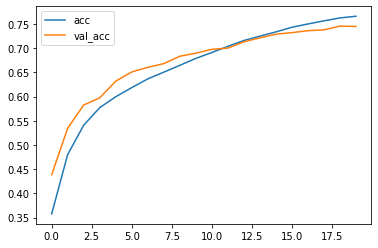

In [48]:
plt.plot(hist['acc'], label = 'acc')
plt.plot(hist['val_acc'], label = 'val_acc')
plt.legend()
plt.show()

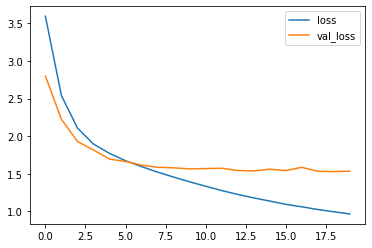

In [49]:
plt.plot(hist['loss'], label = 'loss')
plt.plot(hist['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

In [50]:
# evaluate
train_loss.reset_states()
train_acc.reset_states()
for batch, (x1, x2, x3, x4, x5, y) in enumerate(dataset_test):
    test_step(x1, x2, x3, x4, x5, y)

In [51]:
print('test loss: %.4f'%train_loss.result().numpy())
print('test accuracy: %.4f'%train_acc.result().numpy())

test loss: 1.7152
test accuracy: 0.7450


In [52]:
start_pred = []
end_pred = []
start_true = []
end_true = []
for x1, x2, x3, x4, x5, y in dataset_test:
    x3 = tf.reshape(x3, (-1, 277, len(postag_label)))
    logit = model(
                encoder_inputs = x1,
                encoder_attention_mask = x2,
                postag = x3,
                encoder_token_type_id = None,
                head_mask = None,
                decoder_inputs = x4,
                decoder_attention_mask = x5,
                decoder_token_type_id = None,
    )
    start_pred.extend(np.argmax(logit[0].numpy(), axis = -1).tolist())
    end_pred.extend(np.argmax(logit[1].numpy(), axis = -1).tolist())

    start_true.extend(y[:, 0].numpy().tolist())
    end_true.extend(y[:, 1].numpy().tolist())

In [53]:
from sklearn.metrics import f1_score

In [54]:
start_f1_score = f1_score(start_true, start_pred, average='weighted')
end_f1_score = f1_score(end_true, end_pred, average='weighted')
f1_sc = (start_f1_score+end_f1_score)/2
f1_sc

0.7371509579330184

In [55]:
em = []
for i in range(len(start_pred)):
    if start_pred[i] == start_true[i] and end_pred[i] == end_true[i]:
        em.append(1)
    else:
        em.append(0)

In [56]:
np.mean(em)

0.725